# Lab 3

## Reading CSV files

In [49]:
import pandas as pd

training_mice = pd.read_csv('./pw3_data/EEG_mouse_data_1.csv')
training_mice2 = pd.read_csv('./pw3_data/EEG_mouse_data_2.csv')
##testing_mice = pd.read_csv('./pw3_data/EEG_mouse_data_test.csv')

training_data = pd.concat([training_mice, training_mice2], ignore_index=True)

print(len(training_data[training_data['state'] == 'w']))
print(len(training_data[training_data['state'] == 'n']))
print(len(training_data[training_data['state'] == 'r']))


24360
2839
13664


## Choosing features

In [36]:

feature_list = [
    "state",
    "amplitude_around_1_Hertz",
    "amplitude_around_2_Hertz",
    "amplitude_around_3_Hertz",
    "amplitude_around_4_Hertz",
    "amplitude_around_5_Hertz",
    "amplitude_around_6_Hertz",
    "amplitude_around_7_Hertz",
    "amplitude_around_8_Hertz",
    "amplitude_around_9_Hertz",
    "amplitude_around_10_Hertz",
    "amplitude_around_11_Hertz",
    "amplitude_around_12_Hertz",
    "amplitude_around_13_Hertz",
    "amplitude_around_14_Hertz",
    "amplitude_around_15_Hertz",
    "amplitude_around_16_Hertz",
    "amplitude_around_17_Hertz",
    "amplitude_around_18_Hertz",
    "amplitude_around_19_Hertz",
    "amplitude_around_20_Hertz",
    "amplitude_around_21_Hertz",
    "amplitude_around_22_Hertz",
    "amplitude_around_23_Hertz",
    "amplitude_around_24_Hertz",
    "amplitude_around_25_Hertz",
]

input_training_mice = training_data[feature_list]
##output_training_mice = training_data['state'].to_list()

#training_mice2 = training_mice2[feature_list]
#testing_mice = testing_mice[feature_list]
print(input_training_mice.head())
# print(output_training_mice)

  state  amplitude_around_1_Hertz  amplitude_around_2_Hertz  \
0     n                  0.000009                  0.000014   
1     n                  0.000010                  0.000010   
2     n                  0.000011                  0.000077   
3     w                  0.000003                  0.000031   
4     w                  0.000010                  0.000011   

   amplitude_around_3_Hertz  amplitude_around_4_Hertz  \
0                  0.000013                  0.000014   
1                  0.000011                  0.000015   
2                  0.000034                  0.000019   
3                  0.000044                  0.000016   
4                  0.000012                  0.000017   

   amplitude_around_5_Hertz  amplitude_around_6_Hertz  \
0                  0.000023                  0.000009   
1                  0.000022                  0.000017   
2                  0.000013                  0.000006   
3                  0.000007                  0.000

## Normalize and encode data

balance data and fit and transform all column except "state"  with StandardScaler

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# Encode the state
state = pd.DataFrame(input_training_mice['state'])
encoder.fit(state)

output_training_mice = encoder.transform(state)
input_training_mice = input_training_mice.drop(columns=['state'])

print(encoder.categories_)
print(output_training_mice)


for column in input_training_mice:
    column_data = input_training_mice[column].to_frame()
    scaler.fit(column_data)
    input_training_mice[column] = scaler.transform(column_data)
    


[array(['n', 'r', 'w'], dtype=object)]
       state_n  state_r  state_w
0          1.0      0.0      0.0
1          1.0      0.0      0.0
2          1.0      0.0      0.0
3          0.0      0.0      1.0
4          0.0      0.0      1.0
...        ...      ...      ...
40858      0.0      0.0      1.0
40859      0.0      0.0      1.0
40860      0.0      0.0      1.0
40861      0.0      0.0      1.0
40862      0.0      0.0      1.0

[40863 rows x 3 columns]


## Create model and fold

In [25]:
import keras
from keras import layers
from sklearn.model_selection import KFold

keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

def create_model():
  # 2 inputs
  # 2 hidden nodes
  # 1 output

  mlp = keras.Sequential([
      layers.Input(25),
      layers.Dense(8, activation="tanh"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      layers.Dense(3, activation="tanh"), # Three ouput
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.99),
      loss="mse",
  )

  return mlp

mlp = create_model()
mlp.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 208       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 235 (940.00 Byte)
Trainable params: 235 (940.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [38]:
import numpy as np
history_list = []
trained_mlp = []

for i, (train_index, test_index) in enumerate(kf.split(input_training_mice)):
  # We need to create a new model everytime otherwise fit will continue previous training
 
  mlp = create_model()
  x_train, x_test = input_training_mice.iloc[train_index], input_training_mice.iloc[test_index]
  y_train, y_test = np.array(output_training_mice)[train_index],np.array(output_training_mice)[test_index]
  
  
  history = mlp.fit(
      x=x_train, y=y_train,
      validation_data=(x_test, y_test),
      epochs=50
  )

  history_list.append(history)
  trained_mlp.append(mlp)

Epoch 1/50
852/852 [==============================] - 10s 10ms/step - loss: 0.1248 - val_loss: 0.0757
Epoch 2/50
852/852 [==============================] - 8s 10ms/step - loss: 0.0731 - val_loss: 0.0714
Epoch 3/50
852/852 [==============================] - 9s 11ms/step - loss: 0.0698 - val_loss: 0.0693
Epoch 4/50
852/852 [==============================] - 9s 11ms/step - loss: 0.0685 - val_loss: 0.0687
Epoch 5/50
852/852 [==============================] - 8s 10ms/step - loss: 0.0681 - val_loss: 0.0684
Epoch 6/50
852/852 [==============================] - 8s 10ms/step - loss: 0.0678 - val_loss: 0.0684
Epoch 7/50
852/852 [==============================] - 9s 11ms/step - loss: 0.0677 - val_loss: 0.0682
Epoch 8/50
852/852 [==============================] - 10s 11ms/step - loss: 0.0675 - val_loss: 0.0681
Epoch 9/50
852/852 [==============================] - 8s 10ms/step - loss: 0.0674 - val_loss: 0.0680
Epoch 10/50
852/852 [==============================] - 7s 8ms/step - loss: 0.0673 - val_l

## Plot training history

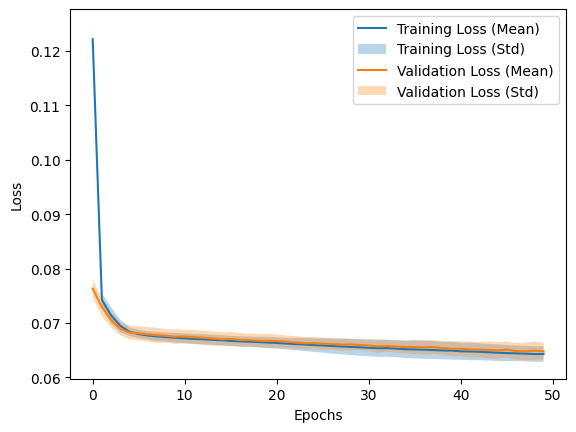

In [39]:
import matplotlib.pyplot as pl
%matplotlib inline

train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

## Performance

426/426 [==============================] - 1s 2ms/step


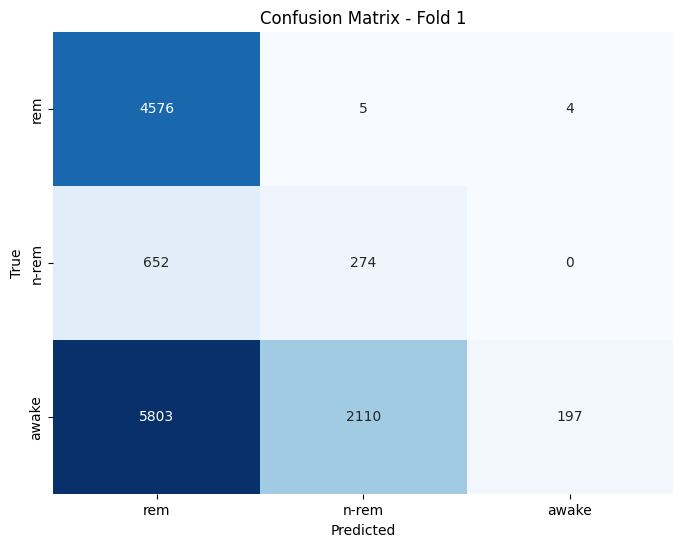

F1 Score - Fold 1: 0.23674166054373402
426/426 [==============================] - 1s 2ms/step


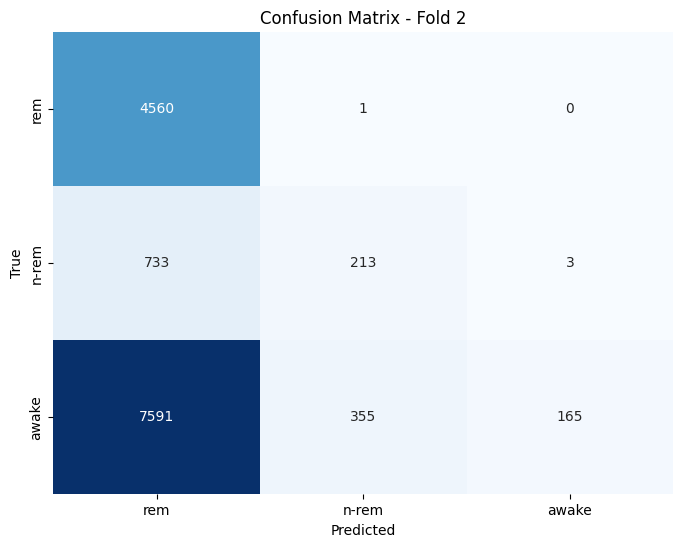

F1 Score - Fold 2: 0.21834301302478176
426/426 [==============================] - 2s 5ms/step


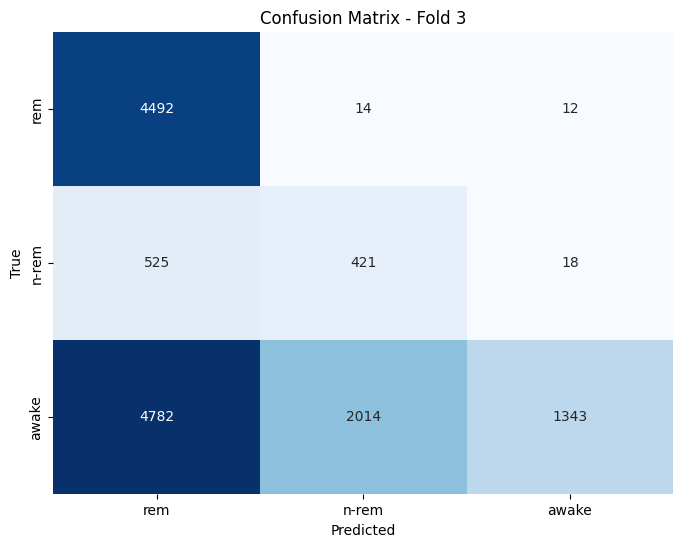

F1 Score - Fold 3: 0.3943312187194226


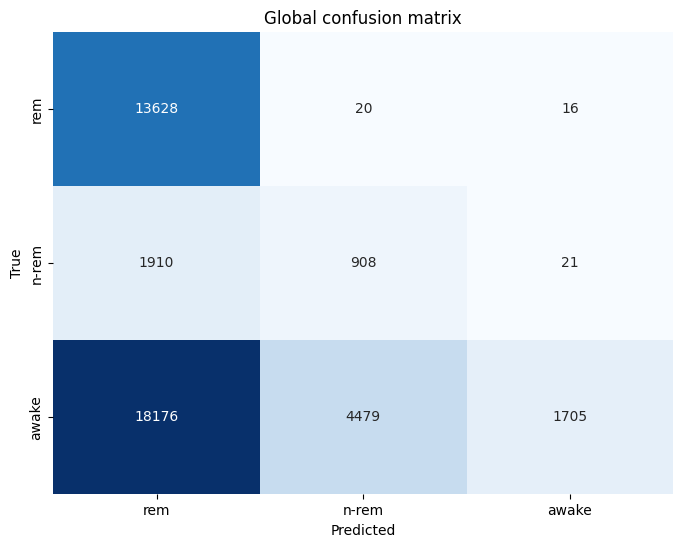

Mean F1 Score across all folds: 0.28313863076264617


In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["rem","n-rem","awake"], yticklabels=["rem","n-rem", "awake"])
    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))

for i, (train_index, test_index) in enumerate(kf.split(input_training_mice)):
    # Evaluate the trained model on the test fold
    predictions = (trained_mlp[i].predict(input_training_mice.loc[test_index]) > 0).astype(int)
    true_labels = (np.array(output_training_mice)[test_index]).astype(int)
    max_predictions = []
    max_true_labels = []
    for prediction in predictions:
        max_predictions.append(np.argmax(prediction))
        
    for true_label in true_labels:
        max_true_labels.append(np.argmax(true_label))
    
    # Compute confusion matrix
    cm = confusion_matrix(max_true_labels, max_predictions)
    mean_confusion_matrix += confusion_matrix(max_true_labels, max_predictions)

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    f1 = f1_score(max_true_labels, max_predictions, average='weighted')
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

## Résultat

On a un modèle qui arrive très bien a reconnaître les états réveiller mais il a beaucoup plus de difficulté a reconnaître les états endormis.
